# 🪼 대구 EDA 및 Preprocessing

In [54]:
import pandas as pd
import numpy as np

In [55]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

In [56]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv
import catboost
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss

In [57]:
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

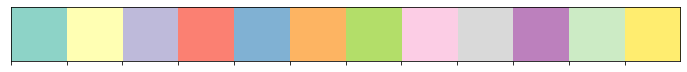

In [96]:
palette = sns.color_palette('Set3')
sns.palplot(palette)

In [58]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [59]:
test.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형'], dtype='object')

In [60]:
cols = ['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형','ECLO']
data = data[cols]

In [61]:
location_pattern = r'(\S+) (\S+) (\S+)'

data[['도시', '구' ,'동']] = data['시군구'].str.extract(location_pattern)
data = data.drop(columns=['시군구'])
data

,ID,사고일시,요일,기상상태,도로형태,노면상태,사고유형,ECLO,도시,구,동
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,단일로 - 기타,건조,차대사람,5,대구광역시,중구,대신동
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,단일로 - 기타,건조,차대사람,3,대구광역시,달서구,감삼동
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,단일로 - 기타,건조,차대사람,3,대구광역시,수성구,두산동
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,단일로 - 기타,건조,차대차,5,대구광역시,북구,복현동
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,단일로 - 기타,건조,차대차,3,대구광역시,동구,신암동
...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19,금요일,맑음,교차로 - 교차로안,건조,차대차,3,대구광역시,수성구,수성동3가
39605,ACCIDENT_39605,2021-12-31 19,금요일,맑음,단일로 - 기타,건조,차대차,3,대구광역시,달서구,상인동
39606,ACCIDENT_39606,2021-12-31 21,금요일,맑음,교차로 - 교차로안,건조,차대차,10,대구광역시,달서구,월성동
39607,ACCIDENT_39607,2021-12-31 22,금요일,맑음,기타 - 기타,건조,차대차,3,대구광역시,달서구,장동


In [62]:
import datetime
data['사고일시'] = pd.to_datetime(data['사고일시'])
test['사고일시'] = pd.to_datetime(test['사고일시'])

<AxesSubplot:xlabel='구', ylabel='ECLO'>

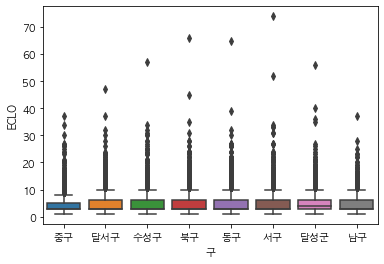

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='구',y='ECLO',data=data)

평균을 벗어나는 큰 값들을 확인

In [64]:
data['연']=data['사고일시'].dt.year
data['월']=data['사고일시'].dt.month
data['일']=data['사고일시'].dt.day
data['시간']=data['사고일시'].dt.hour

In [65]:
test['연']=test['사고일시'].dt.year
test['월']=test['사고일시'].dt.month
test['일']=test['사고일시'].dt.day
test['시간']=test['사고일시'].dt.hour

In [66]:
!pip install holidays

In [67]:
# 공휴일 변수 추가
import holidays
def make_holi(x):
    kr_holi = holidays.KR()

    if x in kr_holi:
        return 1
    else:
        return 0

data["휴일"] = data["사고일시"].map(lambda x : make_holi(x))

In [68]:
# 공휴일 변수 추가
import holidays
def make_holi(x):
    kr_holi = holidays.KR()

    if x in kr_holi:
        return 1
    else:
        return 0

test["휴일"] = test["사고일시"].map(lambda x : make_holi(x))

In [69]:
# 주차 변수 추가
data["누적월"] = data["사고일시"].map(lambda x: datetime.datetime(x.year, x.month, x.day).isocalendar()[1])

# 주차 누적값
week_list=[]
for i in range(len(data['연'])) :
    if data['연'][i] == 2019 :
        week_list.append(int(data['누적월'][i]))
    elif data['연'][i] == 2020 :
        week_list.append(int(data['누적월'][i])+52)
    elif data['연'][i] == 2021 :
        week_list.append(int(data['누적월'][i])+52+53)
    elif data['연'][i] == 2022 :
        week_list.append(int(data['누적월'][i])+52+53+53)
    elif data['연'][i] == 2023 :
        week_list.append(int(data['누적월'][i])+52+53+53+52)
data['누적주']= week_list

In [70]:
# 주차 변수 추가
test["누적월"] = test["사고일시"].map(lambda x: datetime.datetime(x.year, x.month, x.day).isocalendar()[1])

# 주차 누적값
week_list=[]
for i in range(len(test['연'])) :
    if test['연'][i] == 2019 :
        week_list.append(int(test['누적월'][i]))
    elif test['연'][i] == 2020 :
        week_list.append(int(test['누적월'][i])+52)
    elif test['연'][i] == 2021 :
        week_list.append(int(test['누적월'][i])+52+53)
    elif test['연'][i] == 2022 :
        week_list.append(int(test['누적월'][i])+52+53+53)
    elif test['연'][i] == 2023 :
        week_list.append(int(test['누적월'][i])+52+53+53+52)
test['누적주']= week_list

<AxesSubplot:xlabel='월', ylabel='ECLO'>

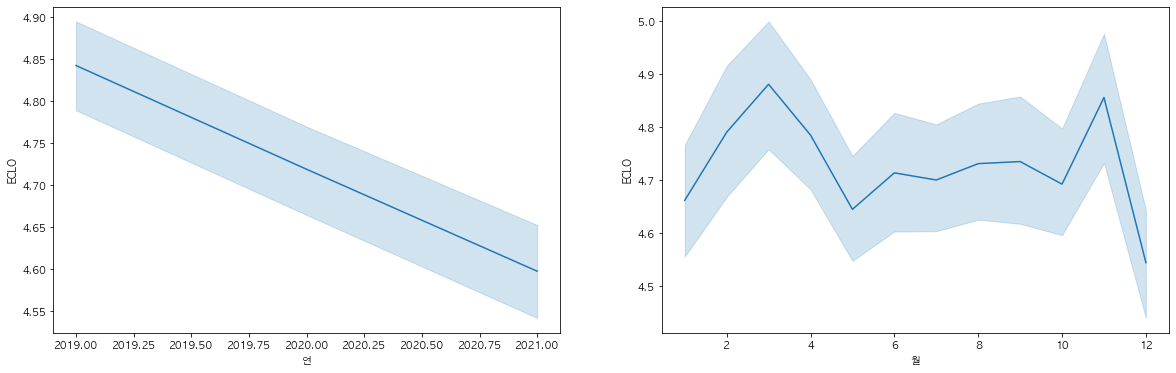

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(data=data,x='연',y='ECLO',ax=axes[0],palette='husl')
sns.lineplot(data=data,x='월',y='ECLO',ax=axes[1])

1. 해가 갈수록 ECLO(equivalent casualty loss only) 하락
2. 3월과 10,11월 (행락철)에 수치가  ➔ 행락철 변수 생성

<AxesSubplot:xlabel='요일', ylabel='ECLO'>

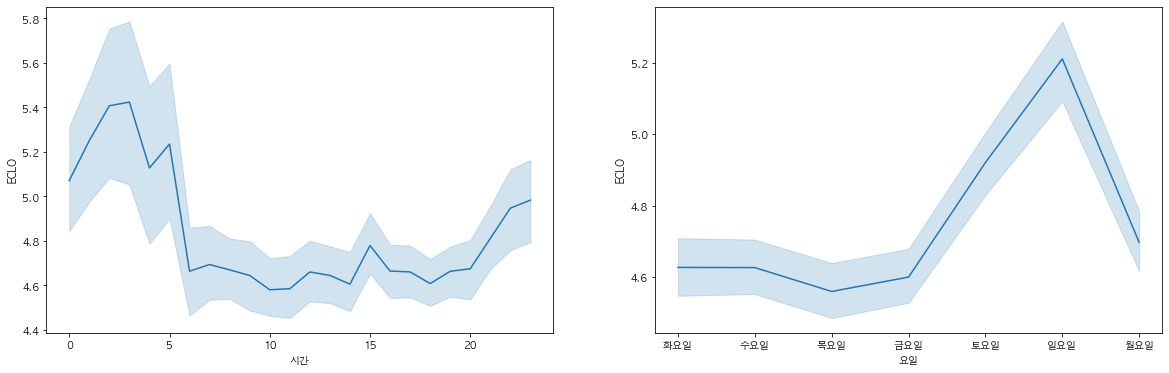

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(data=data,x='시간',y='ECLO',ax=axes[0])
sns.lineplot(data=data,x='요일',y='ECLO',ax=axes[1])

3. 새벽 시간대 (20~3시)에 인명 피해 증가
4. 주말에 인명피해 증가 ➔ 공휴일 파생 변수 생성

<AxesSubplot:xlabel='누적주', ylabel='ECLO'>

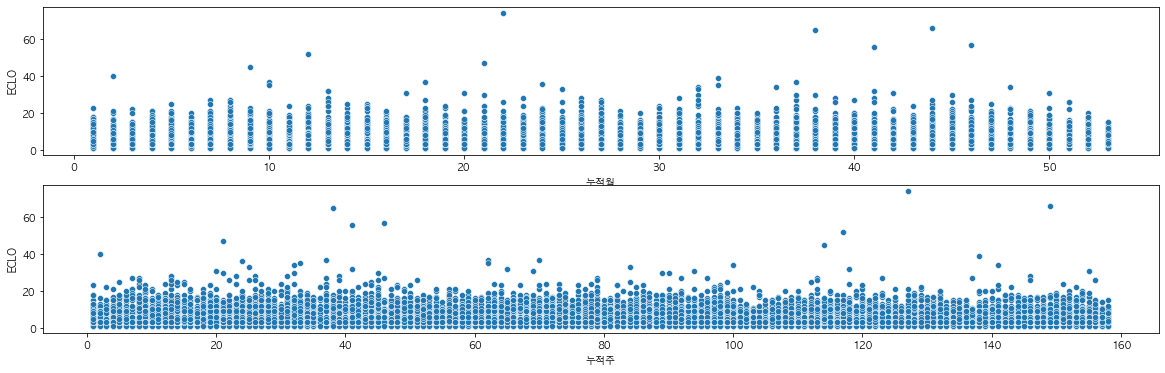

In [73]:
fig, axes = plt.subplots(2, 1, figsize=(20, 6))

sns.scatterplot(data=data,x='누적월',y='ECLO',ax=axes[0])
sns.scatterplot(data=data,x='누적주',y='ECLO',ax=axes[1])

5. 시계열 분포로 확인해보았을 때, 규칙적임이 확인 ➔ 시계열 파생 변수 생성

<AxesSubplot:xlabel='노면상태', ylabel='ECLO'>

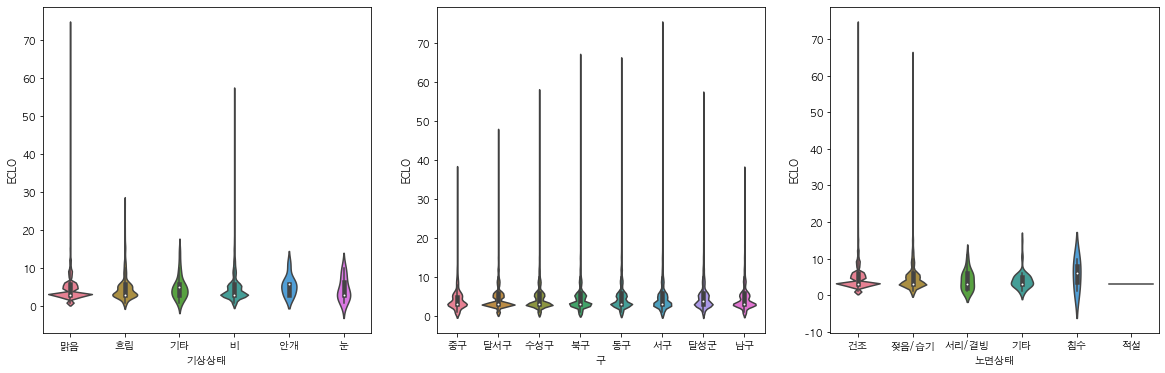

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.violinplot(data=data,x='기상상태',y='ECLO',ax=axes[0],palette='husl')

sns.violinplot(data=data,x='구',y='ECLO',ax=axes[1],palette='husl')

sns.violinplot(data=data,x='노면상태',y='ECLO',ax=axes[2],palette='husl')

In [75]:
gus = data['구'].value_counts().index.to_list()
gus

['달서구', '수성구', '북구', '동구', '서구', '달성군', '남구', '중구']

In [76]:
data['y-m']=data['사고일시'].dt.strftime('%Y-%m')
data['y-m']

0        2019-01
1        2019-01
2        2019-01
3        2019-01
4        2019-01
          ...   
39604    2021-12
39605    2021-12
39606    2021-12
39607    2021-12
39608    2021-12
Name: y-m, Length: 39609, dtype: object

In [77]:
test['y-m']=test['사고일시'].dt.strftime('%Y-%m')
test['y-m']

0        2022-01
1        2022-01
2        2022-01
3        2022-01
4        2022-01
          ...   
10958    2022-12
10959    2022-12
10960    2022-12
10961    2022-12
10962    2022-12
Name: y-m, Length: 10963, dtype: object

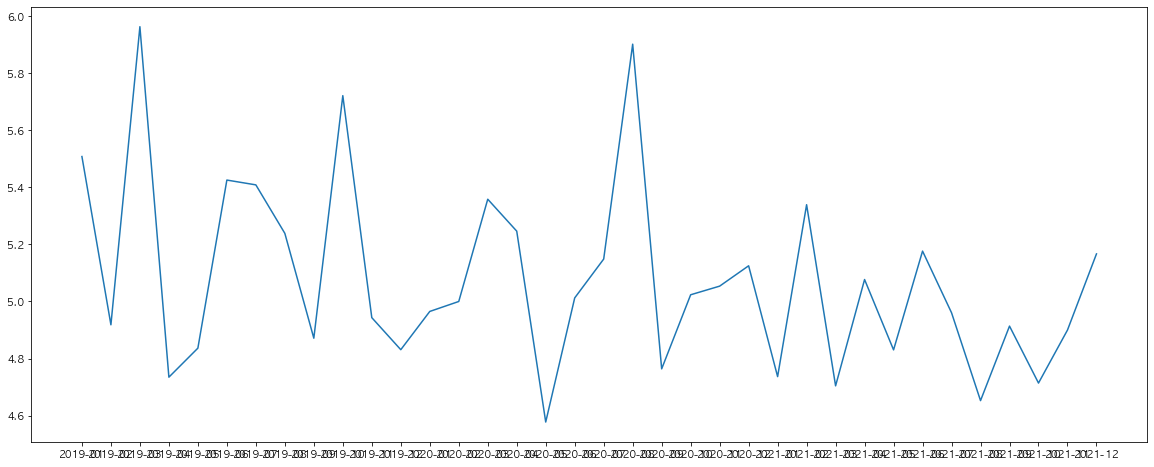

In [79]:
plt.figure(figsize=(20,8))
plt.plot(data[data['구'] == '달성군'].groupby(['y-m'])['ECLO'].mean())

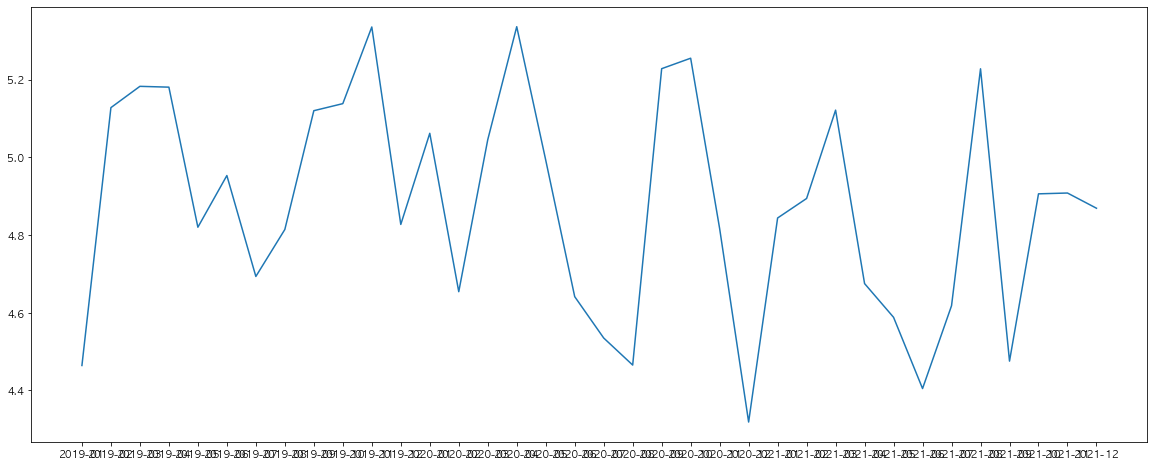

In [80]:
plt.figure(figsize=(20,8))
plt.plot(data[data['구'] == '동구'].groupby(['y-m'])['ECLO'].mean())

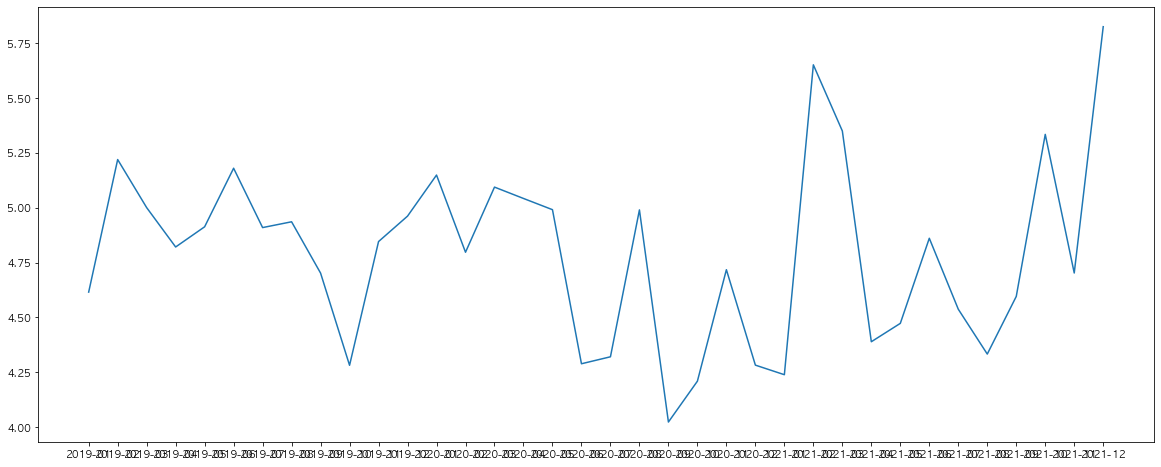

In [81]:
plt.figure(figsize=(20,8))
plt.plot(data[data['구'] == '서구'].groupby(['y-m'])['ECLO'].mean())

In [82]:
df1= pd.pivot_table(data,index='구',values='ECLO',aggfunc='sum')
df1['비율'] = (df1['ECLO']/df1['ECLO'].sum())*100
df1

,ECLO,비율
구,,
남구,11832,6.319838
달서구,45681,24.399637
달성군,14035,7.496528
동구,26115,13.948830
북구,31173,16.650465
서구,16691,8.915180
수성구,31706,16.935157
중구,9987,5.334366


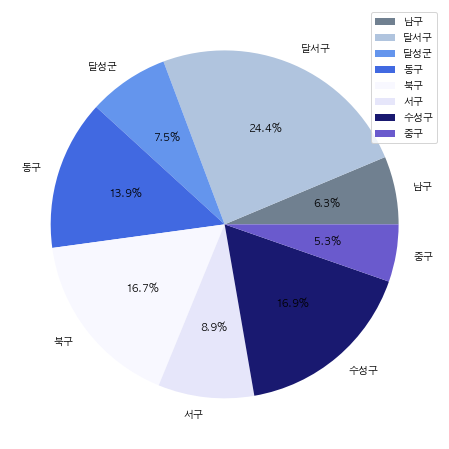

In [83]:
plt.figure(figsize=(10,8))
colors = ['slategrey','lightsteelblue','cornflowerblue','royalblue','ghostwhite','lavender','midnightblue','slateblue','plum']

plt.pie(data = df1,x = 'ECLO',labels=df1.index,autopct=lambda x : '{:.1f}%'.format(x),colors=colors)
plt.legend()
plt.show()

In [84]:
#달서구
dal = data[data['구'] == '달서구'] #24.2%
su = data[data['구'] == '수성구'] #16.9%
buk = data[data['구'] == '북구'] #16.7%

<AxesSubplot:xlabel='동', ylabel='ECLO'>

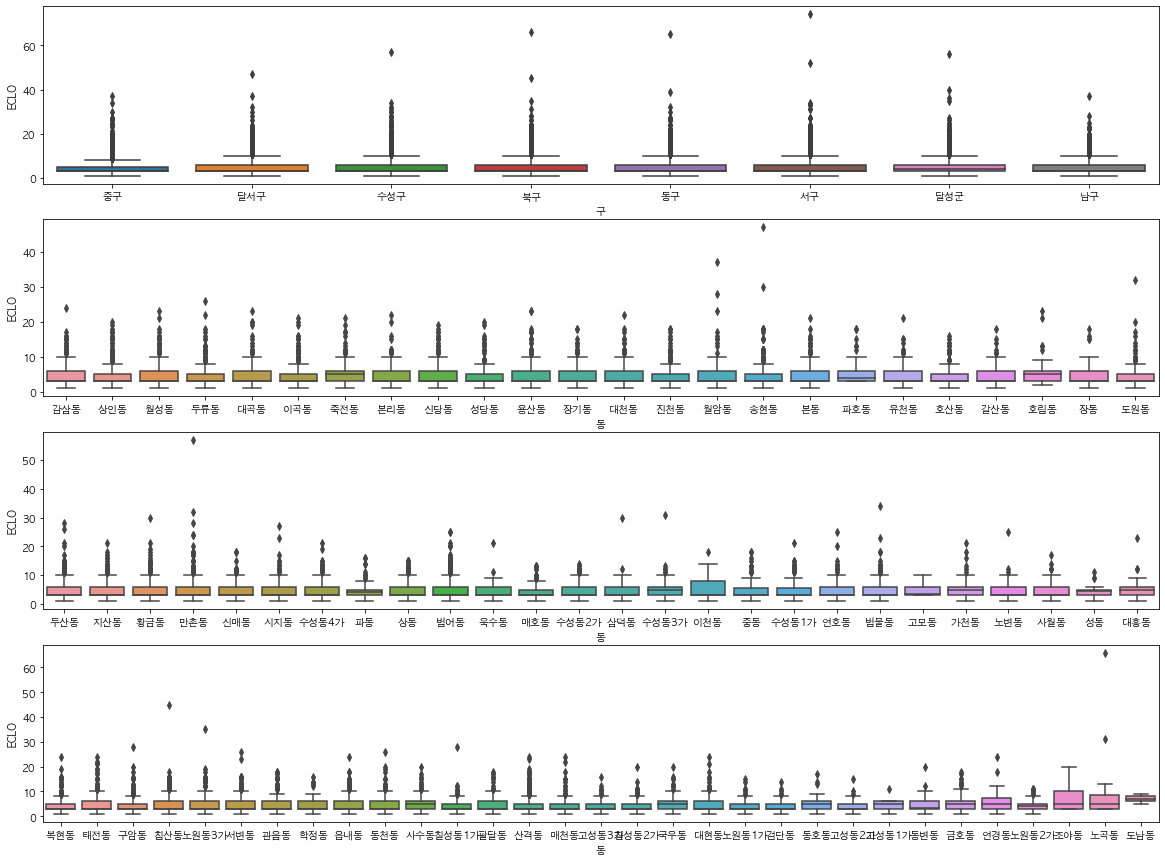

In [85]:
fig, axes = plt.subplots(4, 1, figsize=(20, 15))

sns.boxplot(data=data,x='구',y='ECLO',ax=axes[0])
sns.boxplot(data=dal,x='동',y='ECLO',ax=axes[1]) #달서구
sns.boxplot(data=su,x='동',y='ECLO',ax=axes[2]) #수성구
sns.boxplot(data=buk,x='동',y='ECLO',ax=axes[3]) #북구

/Users/1eeseo/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ECLO', ylabel='Density'>

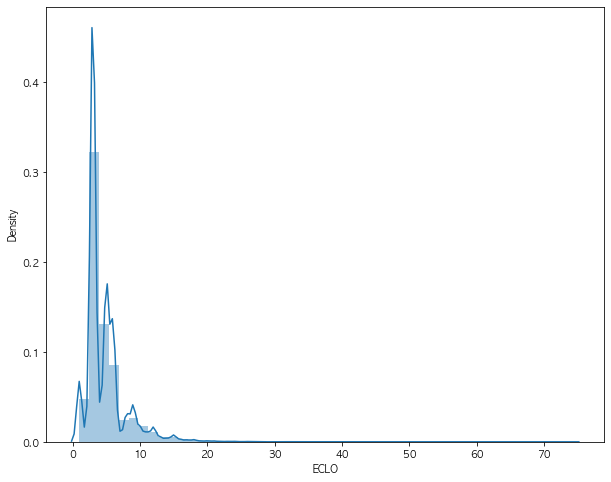

In [86]:
#타겟변수 왜도(분포의 비대칭도) 첨도(분포의 꼬리부분의 길이와 중앙부분의 뾰족함에 대한 정보) 확인
plt.figure(figsize=(10,8))
sns.distplot(data['ECLO'])

In [87]:
#왜도(skewness), 첨도(kurtosis)
data['ECLO'].skew(),data['ECLO'].kurt()

(3.352092952309774, 27.73361826024664)

왜도 > 0오른쪽으로 긴 꼬리를 가짐. 
한쪽 꼬리 부분에 보다 많은 확률값이 분포할 수록, 비대칭도가 커질수록 왜도의 절대값은 증가한다.

첨도 > 0 : 정규분포보다 긴 꼬리를 갖고, 분포가 보다 중앙부분에 덜 집중되게 되므로 중앙부분이 뾰족한 모양을 가지게 된다.
중심 부분이 뾰족해 평균으로 부터 가까운 값이 적으면 첨도가 커진다


# 이상치 확인

<AxesSubplot:ylabel='ECLO'>

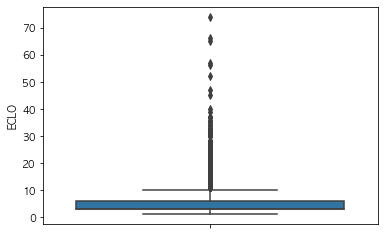

In [88]:
sns.boxplot(y='ECLO',data=data)

In [89]:
location_pattern = r'(\S+) (\S+) (\S+)'

test[['도시', '구' ,'동']] = test['시군구'].str.extract(location_pattern)
test = test.drop(columns=['시군구'])
test

,ID,사고일시,요일,기상상태,도로형태,노면상태,사고유형,연,월,일,시간,휴일,누적월,누적주,y-m,도시,구,동
0,ACCIDENT_39609,2022-01-01 01:00:00,토요일,맑음,교차로 - 교차로안,건조,차대사람,2022,1,1,1,1,52,210,2022-01,대구광역시,수성구,상동
1,ACCIDENT_39610,2022-01-01 01:00:00,토요일,맑음,단일로 - 기타,건조,차대사람,2022,1,1,1,1,52,210,2022-01,대구광역시,수성구,지산동
2,ACCIDENT_39611,2022-01-01 04:00:00,토요일,맑음,교차로 - 교차로안,건조,차대차,2022,1,1,4,1,52,210,2022-01,대구광역시,수성구,수성동2가
3,ACCIDENT_39612,2022-01-01 04:00:00,토요일,맑음,단일로 - 기타,건조,차대차,2022,1,1,4,1,52,210,2022-01,대구광역시,수성구,신매동
4,ACCIDENT_39613,2022-01-01 06:00:00,토요일,맑음,교차로 - 교차로안,건조,차대차,2022,1,1,6,1,52,210,2022-01,대구광역시,달서구,감삼동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,2022-12-31 18:00:00,토요일,맑음,단일로 - 터널,건조,차대차,2022,12,31,18,0,52,210,2022-12,대구광역시,남구,대명동
10959,ACCIDENT_50568,2022-12-31 18:00:00,토요일,맑음,단일로 - 기타,건조,차대차,2022,12,31,18,0,52,210,2022-12,대구광역시,수성구,시지동
10960,ACCIDENT_50569,2022-12-31 20:00:00,토요일,맑음,단일로 - 기타,건조,차대차,2022,12,31,20,0,52,210,2022-12,대구광역시,수성구,연호동
10961,ACCIDENT_50570,2022-12-31 20:00:00,토요일,맑음,교차로 - 교차로부근,건조,차대차,2022,12,31,20,0,52,210,2022-12,대구광역시,수성구,범물동


In [ ]:
road_pattern = r'(.+) - (.+)'

data[['도로형태1', '도로형태2']] = data['도로형태'].str.extract(road_pattern)
data = data.drop(columns=['도로형태'])

In [ ]:
road_pattern = r'(.+) - (.+)'

test[['도로형태1', '도로형태2']] = test['도로형태'].str.extract(road_pattern)
test = test.drop(columns=['도로형태'])

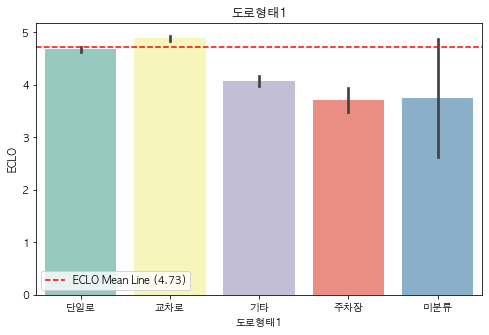

In [100]:
plt.figure(figsize=(8,5))
sns.set_palette('Set3')
sns.barplot(data=data,x='도로형태1',y='ECLO')

avg = data['ECLO'].mean()
plt.axhline(avg, ls='--', color='r', label=f'ECLO Mean Line ({round(avg,2)})')
plt.legend()
plt.title('도로형태1')
plt.show()

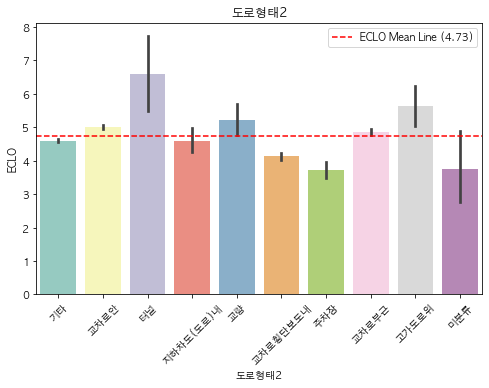

In [102]:
plt.figure(figsize=(8,5))
sns.set_palette('Set3')
sns.barplot(data=data,x='도로형태2',y='ECLO')

avg = data['ECLO'].mean()
plt.axhline(avg, ls='--', color='r', label=f'ECLO Mean Line ({round(avg,2)})')
plt.xticks(rotation=45)
plt.legend()
plt.title('도로형태2')
plt.show()

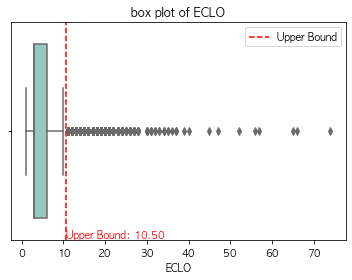

In [103]:
# ECLO upper bound 구하기

Q1 = data['ECLO'].quantile(0.25)
Q3 = data['ECLO'].quantile(0.75)
IQR = Q3-Q1

upper_bound = Q3 + 1.5 * IQR



plt.figure(figsize=(6,4))
sns.boxplot(x='ECLO', data=data)

plt.axvline(x=upper_bound, color='r', linestyle='--', label='Upper Bound')

plt.text(upper_bound+12, 0.5, f'Upper Bound: {upper_bound:.2f}', color='r', ha='center', va='bottom')

plt.legend()

plt.title("box plot of ECLO")
plt.show()

In [104]:
high_df = data[data['ECLO'] > 10.5]
low_df = data[data['ECLO'] <= 10.5]

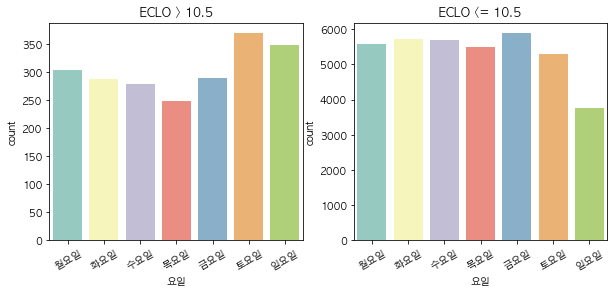

In [116]:
x_order = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.countplot(x='요일', data=high_df, order=x_order, ax=axes[0])
sns.countplot(x='요일', data=low_df, order=x_order, ax=axes[1])

axes[0].tick_params(axis='x', rotation=30)
axes[1].tick_params(axis='x', rotation=30)

axes[0].set_title('ECLO > 10.5')
axes[1].set_title('ECLO <= 10.5')

plt.show()

인명피해가 큰 사고는 주로 주말에 많이 일어나는데

인명피해가 작은 사고는 주로 평일에 빈번하게 일어난다.

In [111]:
data['구'].value_counts().index.to_list()

['달서구', '수성구', '북구', '동구', '서구', '달성군', '남구', '중구']

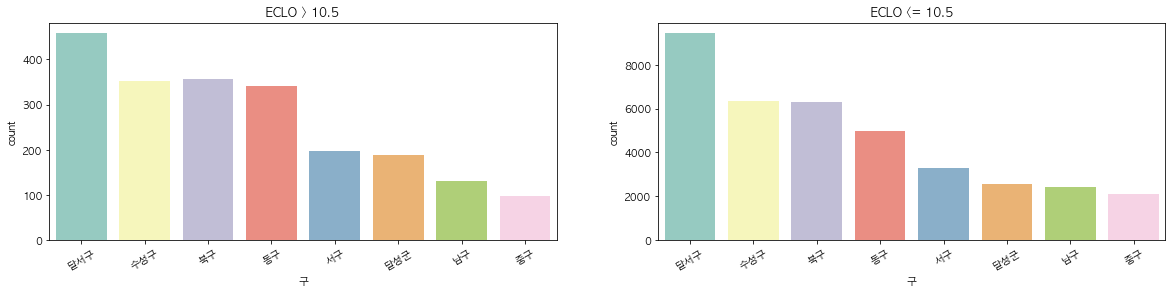

In [112]:
gu_order = ['달서구', '수성구', '북구', '동구', '서구', '달성군', '남구', '중구']

fig, axes = plt.subplots(1,2, figsize=(20,4))
sns.countplot(x='구', data=high_df, order=gu_order, ax=axes[0])
sns.countplot(x='구', data=low_df,order=gu_order, ax=axes[1])

axes[0].tick_params(axis='x', rotation=30)
axes[1].tick_params(axis='x', rotation=30)

axes[0].set_title('ECLO > 10.5')
axes[1].set_title('ECLO <= 10.5')

plt.show()

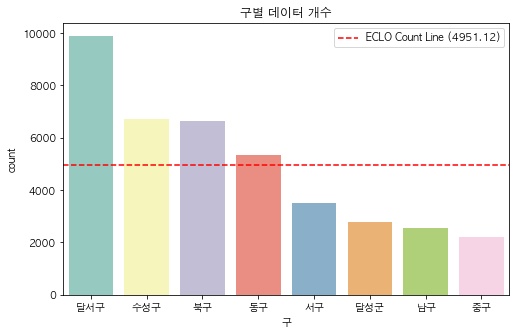

In [137]:
gu_order = ['달서구', '수성구', '북구', '동구', '서구', '달성군', '남구', '중구']

fig = plt.subplots(figsize=(8,5))
sns.countplot(x='구', data=data, order=gu_order)

avg = (data['ECLO'].count())/8
plt.axhline(avg, ls='--', color='r', label=f'ECLO Count Line ({round(avg,2)})')
plt.legend()
plt.title('구별 데이터 개수')
plt.show()


high_ECLO와 low_ECLO 데이터양이 둘 다 달서구가 압도적으로 많음

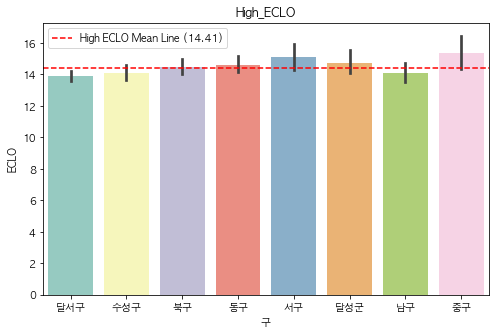

In [119]:
gu_order = ['달서구', '수성구', '북구', '동구', '서구', '달성군', '남구', '중구']

plt.figure(figsize=(8,5))
sns.set_palette('Set3')
sns.barplot(data=high_df,x='구',y='ECLO',order=gu_order)

avg = high_df['ECLO'].mean()
plt.axhline(avg, ls='--', color='r', label=f'High ECLO Mean Line ({round(avg,2)})')
plt.legend()
plt.title('High_ECLO')
plt.show()

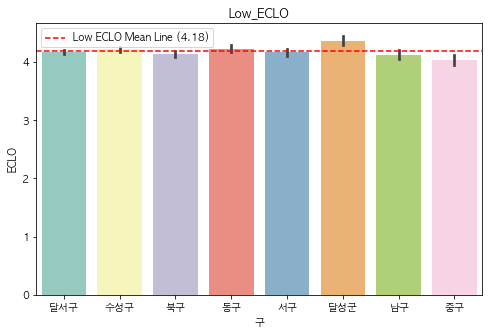

In [120]:
gu_order = ['달서구', '수성구', '북구', '동구', '서구', '달성군', '남구', '중구']

plt.figure(figsize=(8,5))
sns.set_palette('Set3')
sns.barplot(data=low_df,x='구',y='ECLO',order=gu_order)

avg = low_df['ECLO'].mean()
plt.axhline(avg, ls='--', color='r', label=f'Low ECLO Mean Line ({round(avg,2)})')
plt.legend()
plt.title('Low_ECLO')
plt.show()

하지만 ECLO 값으로 봤을 경우엔, 그렇게 큰 차이가 나지 않음을 확인

## ✔️ 결론 : 달서구와 달서구 제외 나머지 구로 나누어서 앙상블 진행